# Autoregression (AR)
## Covid-19 Canada Forecasting
Data source: [OxCGRT Data](https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)

Author: Jianfei Zhang (jianfei.zhang@ualberta.ca)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
from datetime import datetime, timedelta
from statsmodels.tsa.ar_model import AutoReg

In [2]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    d[['CountryName', 'RegionCode']] = d[['CountryName', 'RegionCode']].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    return d

In [3]:
def get_df(d, CountryName, RegionCode = ''):
    d = d[(d['CountryName'] == CountryName) & (d['RegionCode'] == RegionCode)].copy()
    # get weekday column, weekday: Mon=1, Tue=2, ...., Sun=7
    d["weekday"] = d['Date'].dt.dayofweek + 1
    d = d.set_index(['CountryName', 'RegionCode', 'weekday', 'Date'])
    return d

In [4]:
def recursive_forecast(train, coef, lookbacks, pred_steps):
    history = train[len(train)-lookbacks:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for p in range(pred_steps):
        lag = [history[i] for i in range(len(history)-lookbacks,len(history))]
        yhat = coef[0]
        for d in range(lookbacks):
            yhat += coef[d+1] * lag[lookbacks-d-1]
        predictions.append(yhat[0])
        history.append(yhat)
        #print('predicted=%f'%(yhat))
    return predictions

In [6]:
d = load_OxCGRT()
d_CA = get_df(d, 'Canada')

In [7]:
def daily_forecast(target, end_weekday = 5, date_col = 'Date', weekday = 'weekday', lookbacks = 28, pred_steps = 28):
    df = d_CA[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df.diff().fillna(0)
    train = df.values
    model = AutoReg(train, lags=lookbacks, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    predictions = recursive_forecast(train, coef, lookbacks, pred_steps)
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta(i+1) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target[0]: predictions}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col, weekday])
    df.index = df.index.droplevel(['CountryName', 'RegionCode'])
    df_merge = df.join(df_forecast, how='outer')
    df_merge.index = df_merge.index.droplevel(['weekday'])
    df_merge.plot(title = 'AR Model: Daily New ' + target[0], figsize=(8,3), lw=1)
    plt.show()
    df_forecast = df_forecast.cumsum()
    df_forecast = df_forecast[df_forecast.index.get_level_values(weekday) == end_weekday].fillna(0)
    first_week = df_forecast['Predicted'+target[0]].iloc[0]
    df_forecast = df_forecast.diff()
    df_forecast['Predicted'+target[0]].iloc[0] = first_week
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('(StartDate through Date) Weekly New ' + target[0] + ' (via Daily Prediction):\n')
    display(df_forecast.round(0).astype('int32'))

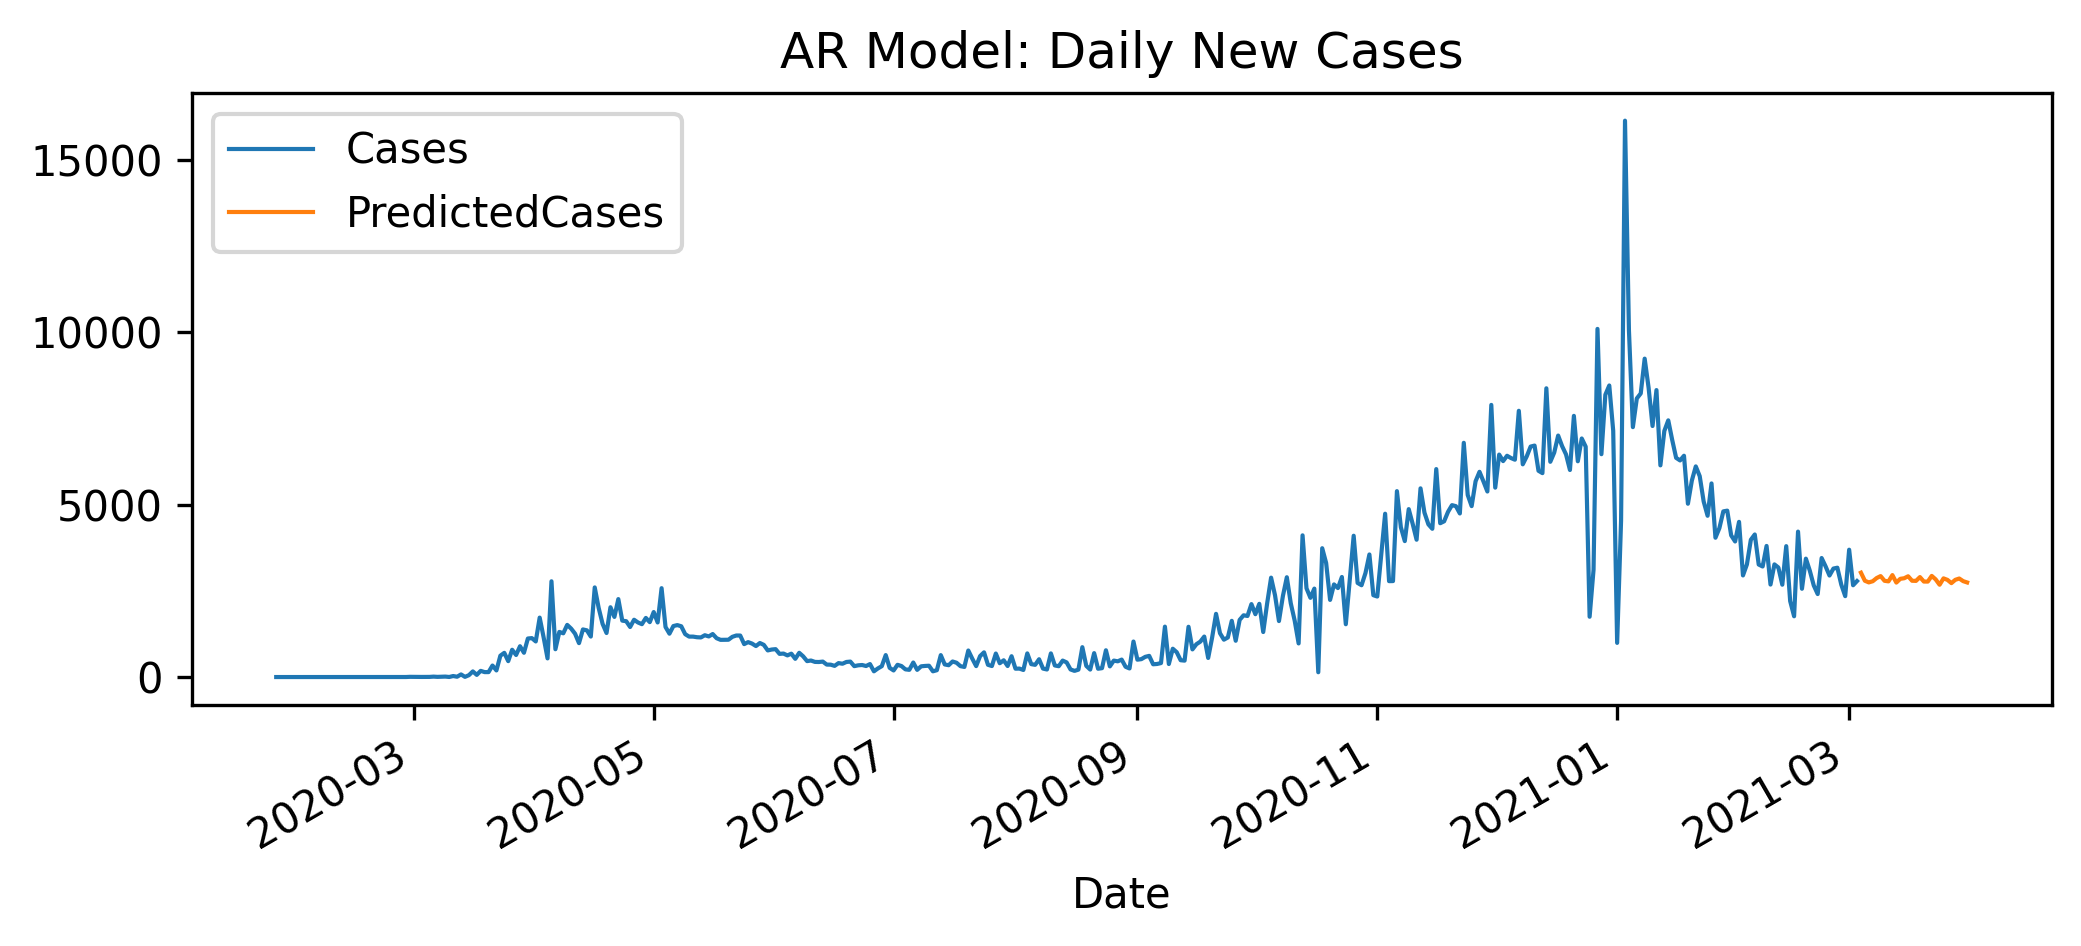

(StartDate through Date) Weekly New Cases (via Daily Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,19939
2021-03-17,3,2021-03-10,19905
2021-03-24,3,2021-03-17,19673
2021-03-31,3,2021-03-24,19610


In [8]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
daily_forecast(['Cases'], 3)

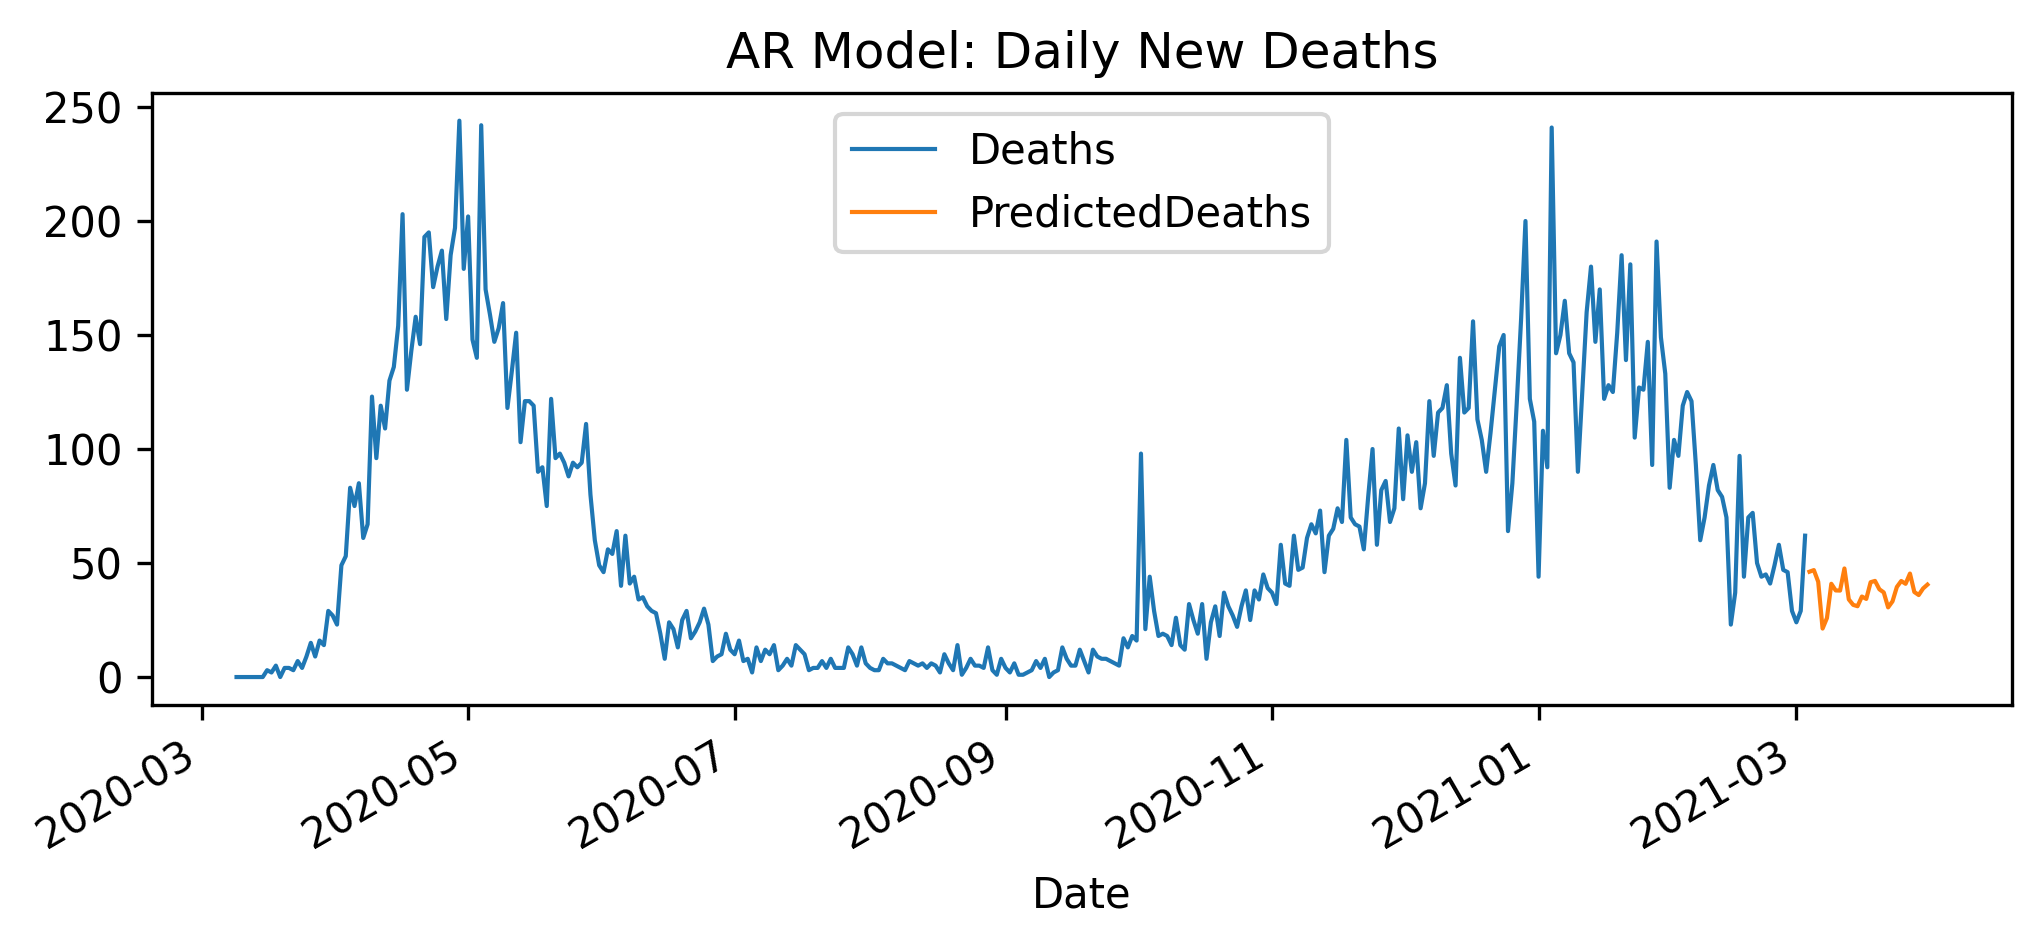

(StartDate through Date) Weekly New Deaths (via Daily Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,261
2021-03-17,3,2021-03-10,252
2021-03-24,3,2021-03-17,263
2021-03-31,3,2021-03-24,281


In [9]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
daily_forecast(['Deaths'], 3)

In [10]:
def weekly_forecast(target, end_weekday, date_col = 'Date', weekday = 'weekday', lookbacks = 4, pred_steps = 4, interval = 7):
    df = d_CA[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df[df.index.get_level_values(weekday) == end_weekday].fillna(0)
    df = df.diff().fillna(0)
    train = df.values
    model = AutoReg(train, lags=lookbacks, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    predictions = recursive_forecast(train, coef, lookbacks, pred_steps)
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta((i+1)*interval) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target[0]: predictions}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col,weekday])
    df.index = df.index.droplevel(['CountryName', 'RegionCode'])
    df_merge = df.join(df_forecast, how='outer')
    df_merge.index = df_merge.index.droplevel(['weekday'])
    df_merge.plot(title = 'AR Model: Weekly New ' + target[0], figsize=(8,3), lw=1)
    plt.show()
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('(StartDate through Date) Weekly New ' + target[0] + ' (via Weekly Prediction):\n')
    display(df_forecast.round(0).astype('int32'))

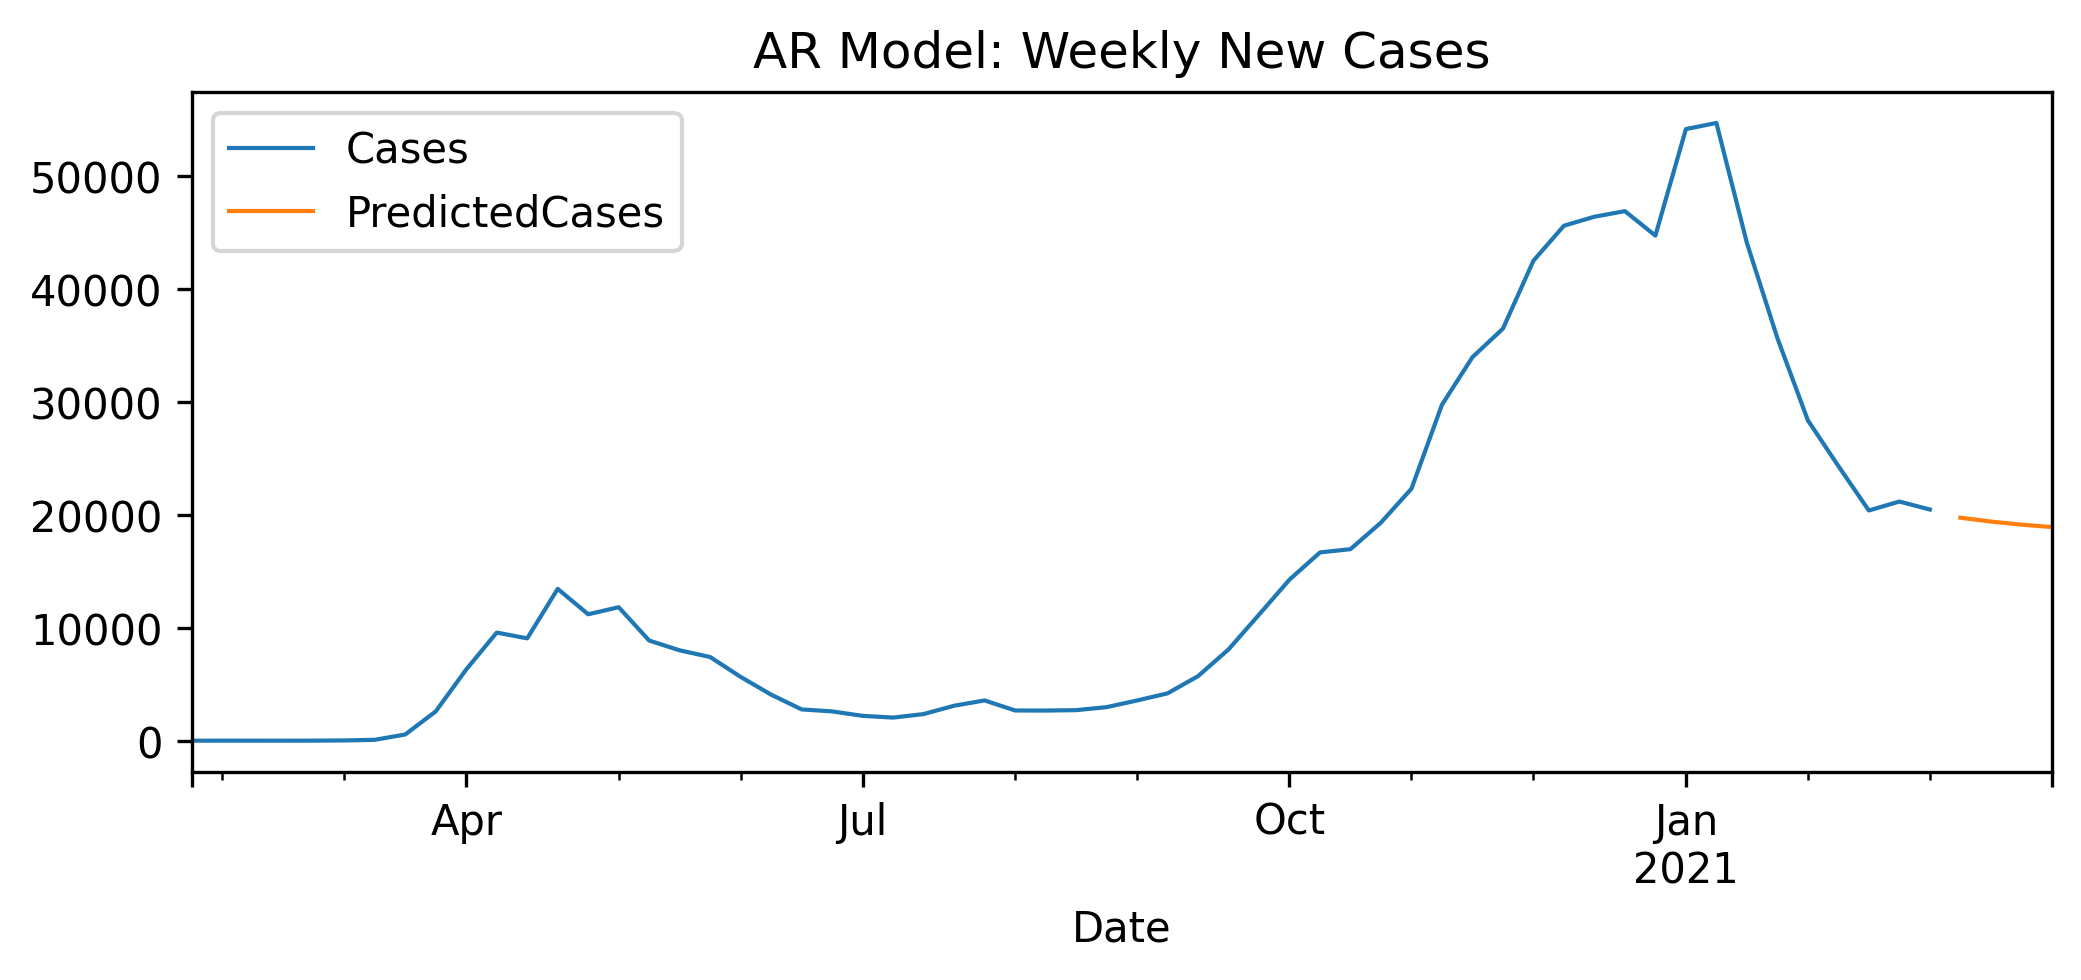

(StartDate through Date) Weekly New Cases (via Weekly Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,19762
2021-03-17,3,2021-03-10,19421
2021-03-24,3,2021-03-17,19147
2021-03-31,3,2021-03-24,18932


In [11]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
weekly_forecast(['Cases'], 3)

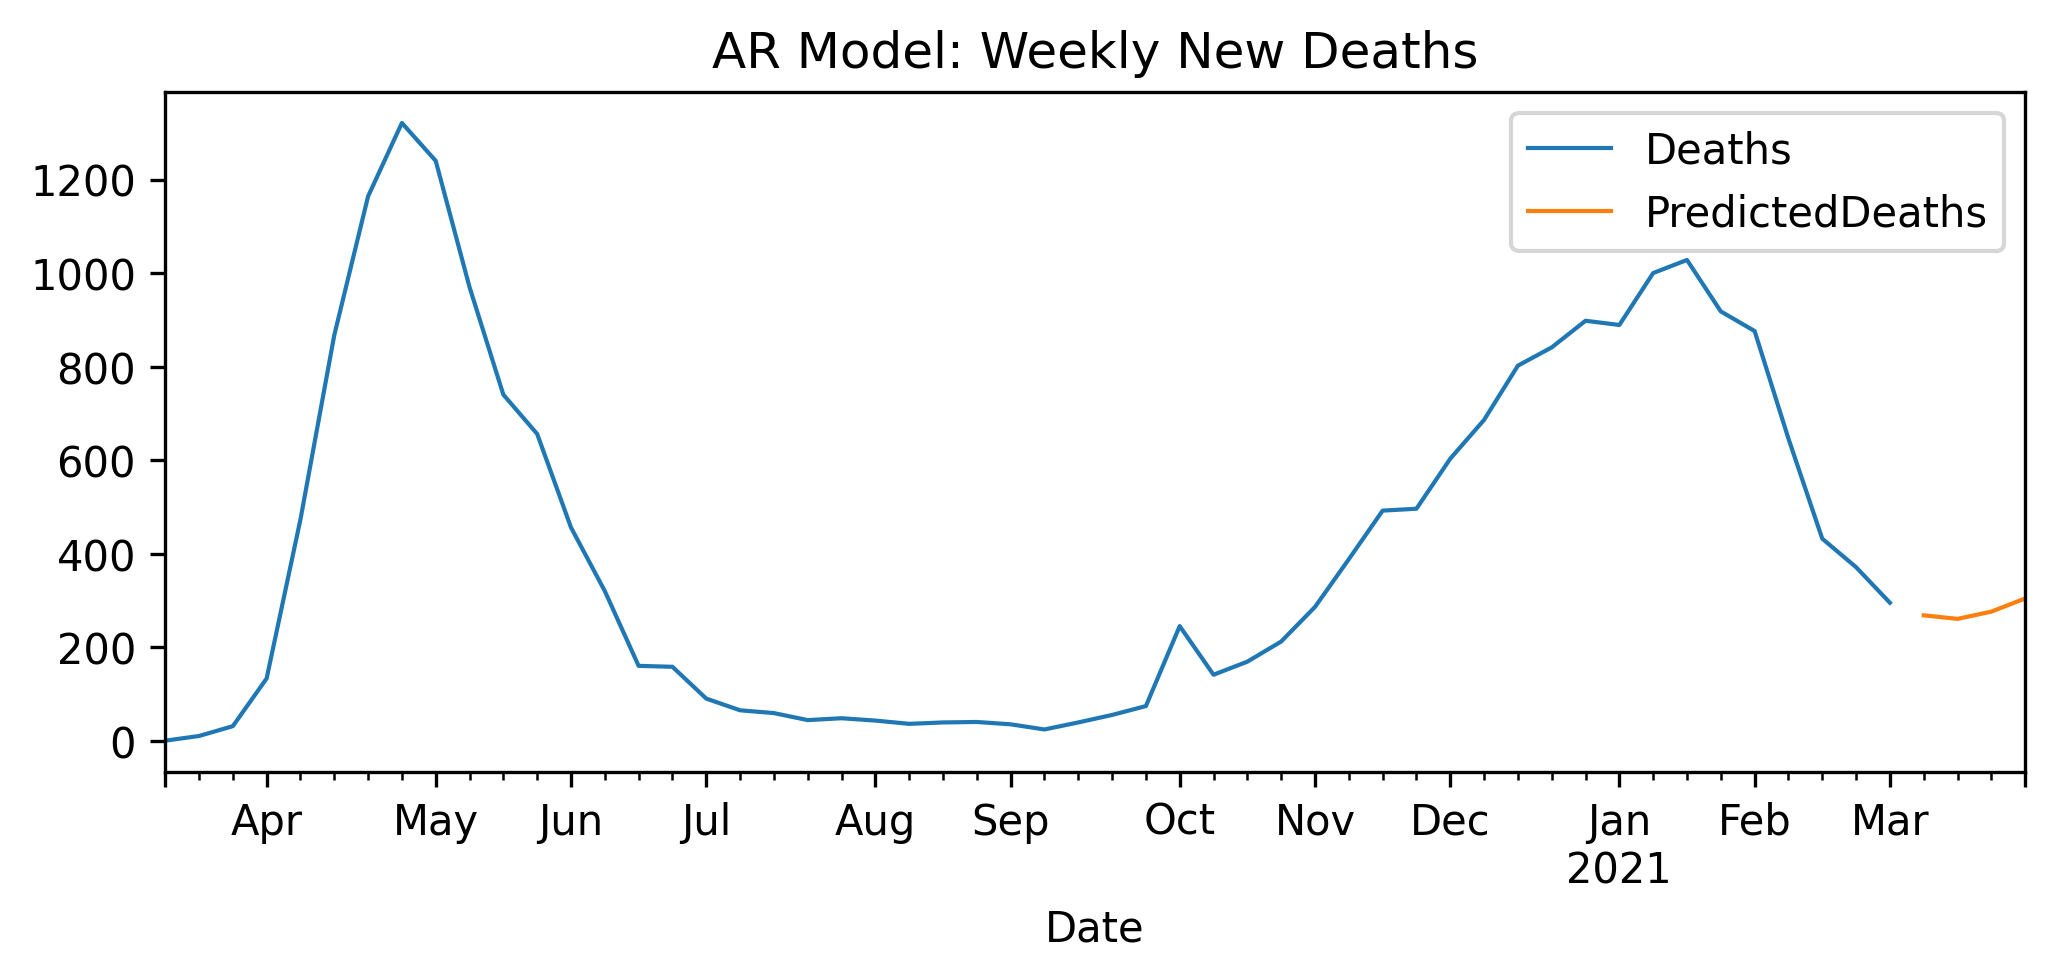

(StartDate through Date) Weekly New Deaths (via Weekly Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-10,3,2021-03-03,268
2021-03-17,3,2021-03-10,260
2021-03-24,3,2021-03-17,276
2021-03-31,3,2021-03-24,304


In [12]:
# 2nd parameter: the end day of every week, Mon = 1,..., Sun = 7. For our internal competition, taking value of 5 (Friday)
weekly_forecast(['Deaths'], 3)